# Dijagnosticka klasifikacija raka dojke

Ucitavanje potrebnih biblioteka

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from scipy import stats


**1. Pocetno preprocesiranje podataka**

*Ucitavanje dataset-a*

In [19]:
# lista imena kolona
column_names = [
    "id",
    "diagnosis",    # ciljna promenljiva (B -> 0 ili M -> 1)
    "mean radius", 
    "mean texture", 
    "mean perimeter", 
    "mean area",
    "mean smoothness", 
    "mean compactness", 
    "mean concavity", 
    "mean concave points",
    "mean symmetry", 
    "mean fractal dimension",
    "radius se", 
    "texture se", 
    "perimeter se", 
    "area se",
    "smoothness se", 
    "compactness se", 
    "concavity se", 
    "concave points se",
    "symmetry se", 
    "fractal dimension se",
    "worst radius", 
    "worst texture", 
    "worst perimeter", 
    "worst area",
    "worst smoothness", 
    "worst compactness", 
    "worst concavity", 
    "worst concave points",
    "worst symmetry", 
    "worst fractal dimension"
]

# učitavanje sa imenima kolona
df = pd.read_csv("data.csv", names=column_names)

*Ciscenje i pocetna analiza*

In [20]:
# mapiranje B -> 0, M -> 1
df["diagnosis"] = df["diagnosis"].map({"B": 0, "M": 1}) 

# Provera nedostajucih vrednosti
print("\nNedostajuce vrednosti po kolonama:\n", df.isnull().sum())

# Uklanjanje atributa koji ocigledno ne uticu na izlaz
if 'id' in df.columns:
    df = df.drop(columns=['id'])

print("\nPrvih 5 redova:\n", df.head())
print("\nBroj uzoraka po klasama:\n", df["diagnosis"].value_counts())
df.info()


Nedostajuce vrednosti po kolonama:
 id                         0
diagnosis                  0
mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius se                  0
texture se                 0
perimeter se               0
area se                    0
smoothness se              0
compactness se             0
concavity se               0
concave points se          0
symmetry se                0
fractal dimension se       0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
dtype: int64

Prvih 5 redova:
    d

*Detekcija i uklanjanje anomalija*

In [21]:
def remove_outliers_zscore(df, threshold=3):
    """
    Uklanja anomalije iz DataFrame-a na osnovu Z-score metode.
    """
    z_scores = stats.zscore(df)
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < threshold).all(axis=1)
    return df[filtered_entries]

# Uklanjanje anomalija iz DataFrame-a
df_no_outliers = remove_outliers_zscore(df, threshold=3)

print("Originalni oblik skupa podataka:", df.shape)
print("Oblik skupa podataka nakon uklanjanja anomalija:", df_no_outliers.shape)

# Ponovna podela podataka na setove (koristeći novi DataFrame)
X = df_no_outliers.drop('diagnosis', axis=1)
y = df_no_outliers['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Originalni oblik skupa podataka: (569, 31)
Oblik skupa podataka nakon uklanjanja anomalija: (495, 31)


**2. Eksplorativna analiza skupa**

*Analiza i prikaz korelacije*

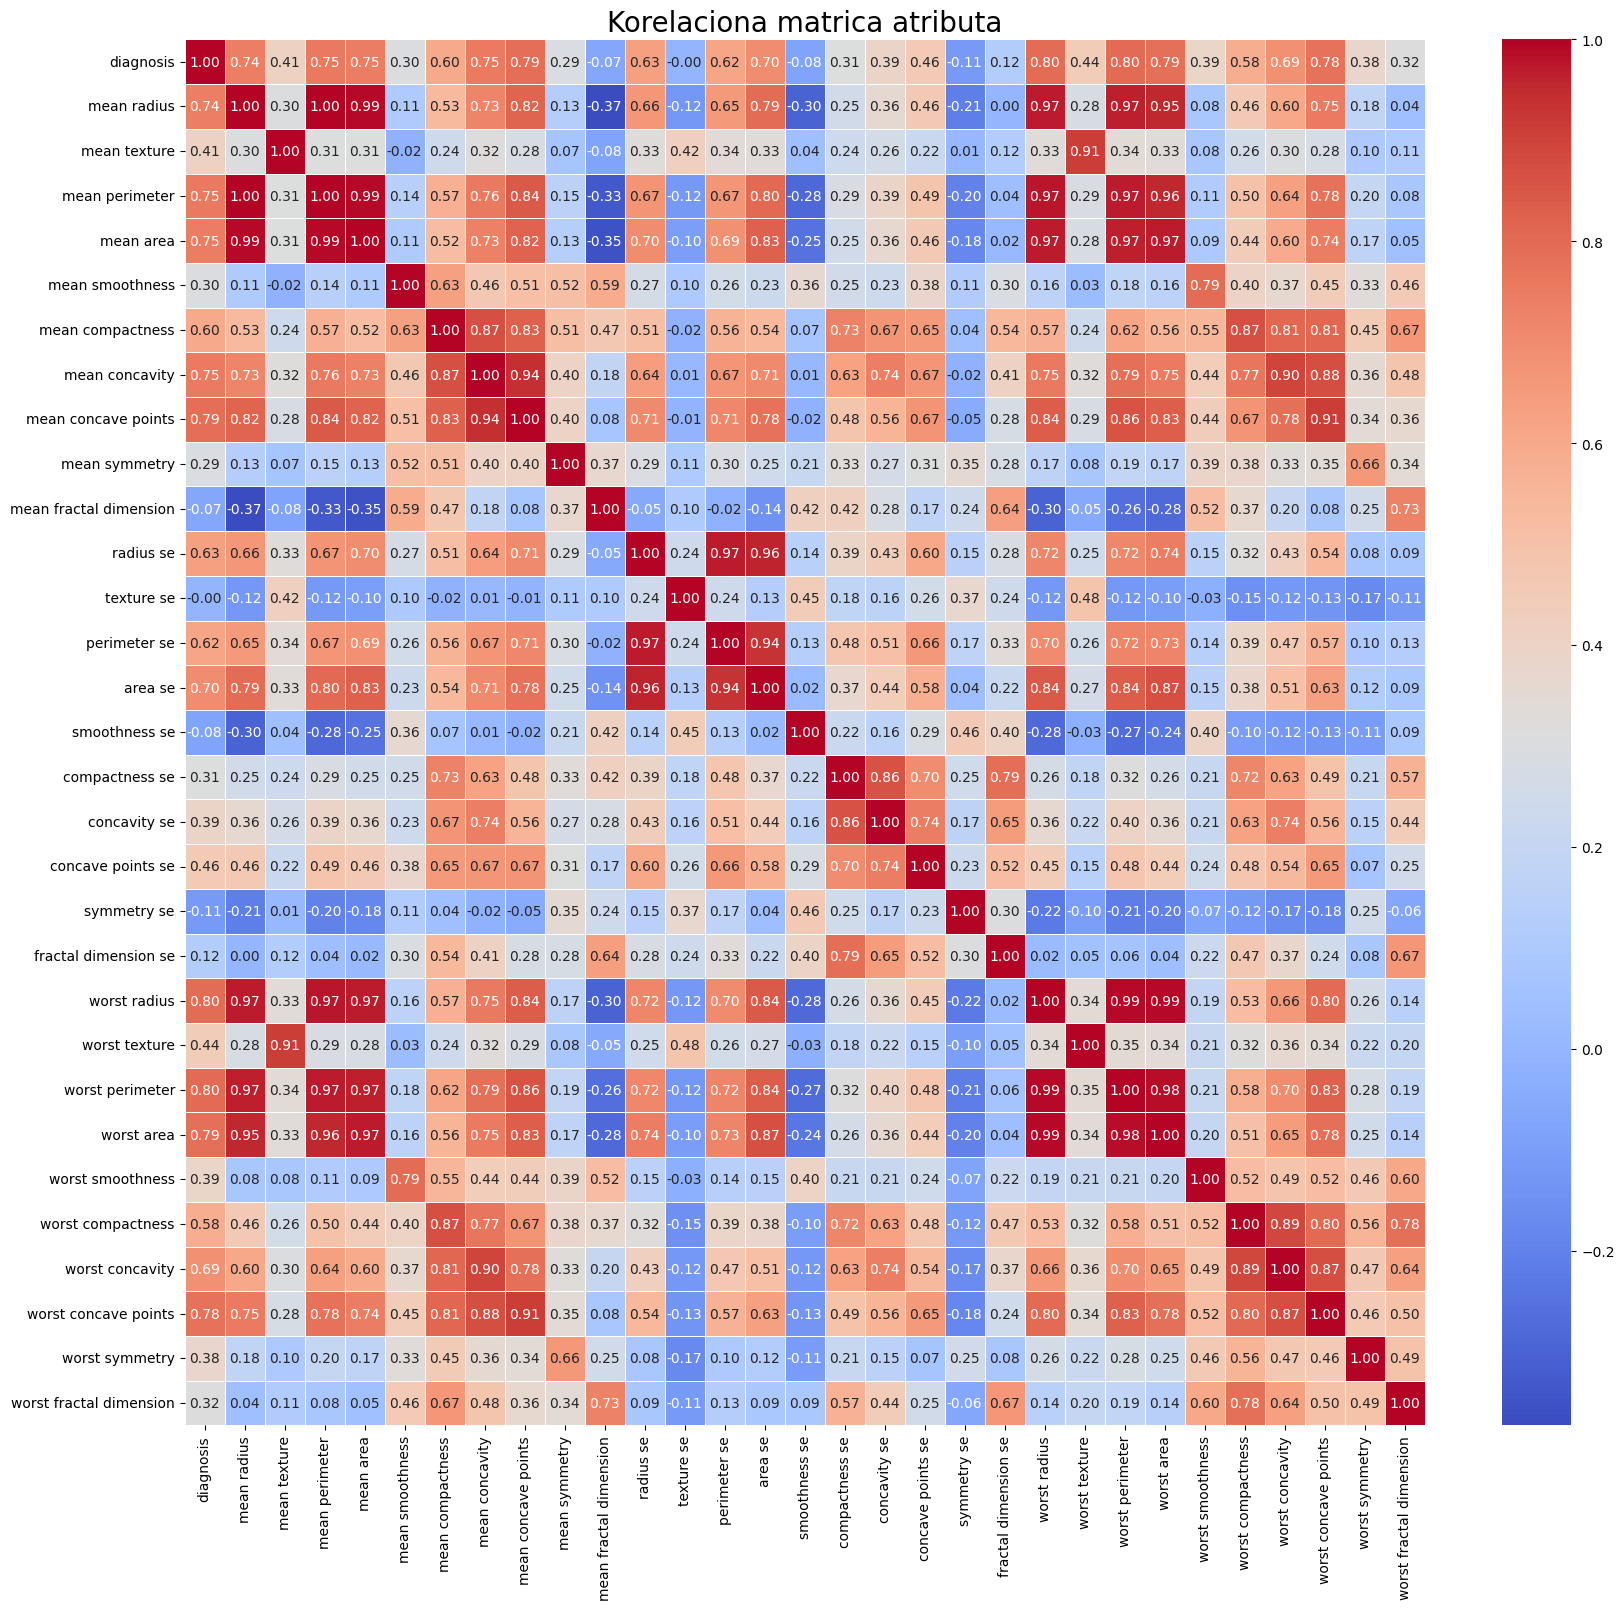

In [22]:
correlation_matrix = df_no_outliers.corr()

# Vizualizacija korelacione matrice
plt.figure(figsize=(20, 18))
sbn.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Korelaciona matrica atributa', fontsize=20)
plt.show()


**3. Odabir i treniranje modela**

*Odabir atributa i setova*

In [23]:
# Odvajanje atributa (X) i ciljne promenljive (y)
X = df_no_outliers.drop('diagnosis', axis=1)
y = df_no_outliers['diagnosis']

# Podela podataka na trening (80%) i test (20%) set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Oblik trening skupa: {X_train.shape}")
print(f"Oblik test skupa: {X_test.shape}")

# Skaliranje atributa (obavezno za LR, SVM, KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

predictions = {}
models = {}
performance_metrics = {}

Oblik trening skupa: (396, 30)
Oblik test skupa: (99, 30)


**Trening modela**

Logisticka regresija

In [24]:
print("\n--- Optimizacija modela: Logisticka Regresija ---")

param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

grid_search_lr = GridSearchCV(
    estimator=LogisticRegression(random_state=42), 
    param_grid=param_grid_lr, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1
)

grid_search_lr.fit(X_train_scaled, y_train)

best_lr = grid_search_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test_scaled)
predictions['Logisticka Regresija'] = y_pred_lr
models['Logisticka Regresija'] = best_lr

print(f"Najbolji parametri za Logisticku Regresiju: {grid_search_lr.best_params_}")
print(f"Tacnost na test podacima: {accuracy_score(y_test, y_pred_lr):.4f}")


--- Optimizacija modela: Logisticka Regresija ---
Najbolji parametri za Logisticku Regresiju: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Tacnost na test podacima: 0.9798


Slucajna suma

In [25]:
print("\n--- Optimizacija modela: Slucajna suma ---")

param_grid_rf = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42), 
    param_grid=param_grid_rf, 
    cv=5, 
    scoring="accuracy", 
    n_jobs=-1
)

grid_search_rf.fit(X_train, y_train)

best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
predictions['Slucajna suma'] = y_pred_rf
models['Slucajna suma'] = best_rf

print(f"Najbolji parametri za Slucajnu sumu: {grid_search_rf.best_params_}")
print(f"Tacnost na test podacima sa optimizovanim Random Forest modelom: {accuracy_score(y_test, y_pred_rf):.4f}")


--- Optimizacija modela: Slucajna suma ---
Najbolji parametri za Slucajnu sumu: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Tacnost na test podacima sa optimizovanim Random Forest modelom: 0.9394
Najbolji parametri za Slucajnu sumu: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Tacnost na test podacima sa optimizovanim Random Forest modelom: 0.9394


KNN

In [26]:
print("\n--- Optimizacija modela: KNN ---")

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 13],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search_knn = GridSearchCV(
    estimator=KNeighborsClassifier(), 
    param_grid=param_grid_knn, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1
)

grid_search_knn.fit(X_train_scaled, y_train)

best_knn = grid_search_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test_scaled)
predictions['KNN'] = y_pred_knn
models['KNN'] = best_knn

print(f"Najbolji parametri za KNN: {grid_search_knn.best_params_}")
print(f"Tacnost na test podacima sa optimizovanim KNN modelom: {accuracy_score(y_test, y_pred_knn):.4f}")


--- Optimizacija modela: KNN ---
Najbolji parametri za KNN: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
Tacnost na test podacima sa optimizovanim KNN modelom: 0.9495


SVM

In [27]:
print("\n--- Optimizacija modela: SVM ---")

param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'kernel': ['linear', 'rbf']
}

grid_search_svm = GridSearchCV(
    estimator=SVC(random_state=42), 
    param_grid=param_grid_svm, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1
)

grid_search_svm.fit(X_train_scaled, y_train)

best_svm = grid_search_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test_scaled)
predictions['SVM'] = y_pred_svm
models['SVM'] = best_svm

print(f"Najbolji parametri za SVM: {grid_search_svm.best_params_}")
print(f"Tacnost na test podacima sa optimizovanim SVM modelom: {accuracy_score(y_test, y_pred_svm):.4f}")


--- Optimizacija modela: SVM ---
Najbolji parametri za SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Tacnost na test podacima sa optimizovanim SVM modelom: 0.9798
Najbolji parametri za SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Tacnost na test podacima sa optimizovanim SVM modelom: 0.9798


***Uporedjivanje preformanis***


 Rezultati i poredjenje modela:


--- Model: Logisticka Regresija ---


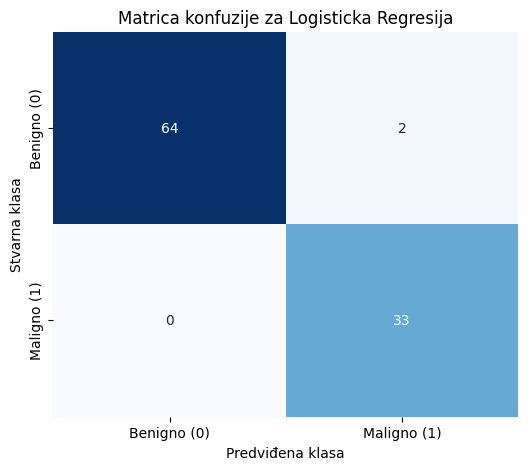

Izvestaj o klasifikaciji:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        66
           1       0.94      1.00      0.97        33

    accuracy                           0.98        99
   macro avg       0.97      0.98      0.98        99
weighted avg       0.98      0.98      0.98        99


--- Model: Slucajna suma ---


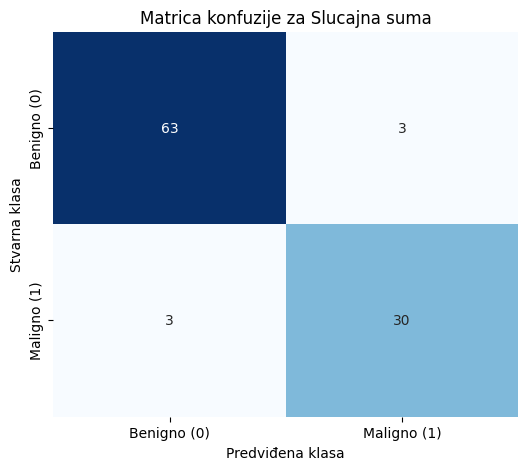

Izvestaj o klasifikaciji:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        66
           1       0.91      0.91      0.91        33

    accuracy                           0.94        99
   macro avg       0.93      0.93      0.93        99
weighted avg       0.94      0.94      0.94        99


--- Model: KNN ---


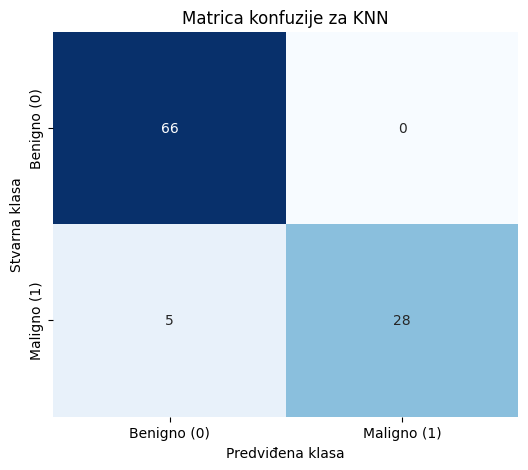

Izvestaj o klasifikaciji:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        66
           1       1.00      0.85      0.92        33

    accuracy                           0.95        99
   macro avg       0.96      0.92      0.94        99
weighted avg       0.95      0.95      0.95        99


--- Model: SVM ---


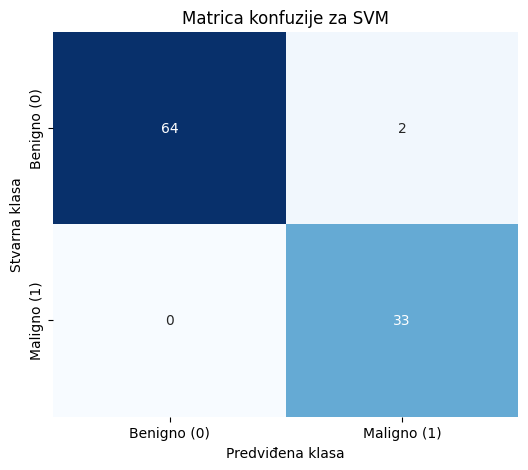

Izvestaj o klasifikaciji:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        66
           1       0.94      1.00      0.97        33

    accuracy                           0.98        99
   macro avg       0.97      0.98      0.98        99
weighted avg       0.98      0.98      0.98        99



In [28]:
print("\n Rezultati i poredjenje modela:\n")

for model_name, y_pred in predictions.items():
    print(f"\n--- Model: {model_name} ---")
    
    # Računanje metrika i čuvanje za tabelu
    performance_metrics[model_name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    }

    # Matrica konfuzije
    cm = confusion_matrix(y_test, y_pred)
    
    # Prikaz matrice konfuzije
    plt.figure(figsize=(6, 5))
    sbn.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Benigno (0)', 'Maligno (1)'],
                yticklabels=['Benigno (0)', 'Maligno (1)'])
    plt.xlabel('Predviđena klasa')
    plt.ylabel('Stvarna klasa')
    plt.title(f'Matrica konfuzije za {model_name}')
    plt.show()
    
    # Prikaz izveštaja o klasifikaciji
    print("Izvestaj o klasifikaciji:")
    print(classification_report(y_test, y_pred))

***Analiza i tumacenje rezultata***

--- Tabela performansi svih modela ---

                      Accuracy  Precision  Recall  F1-Score
Logisticka Regresija    0.9798     0.9429  1.0000    0.9706
Slucajna suma           0.9394     0.9091  0.9091    0.9091
KNN                     0.9495     1.0000  0.8485    0.9180
SVM                     0.9798     0.9429  1.0000    0.9706


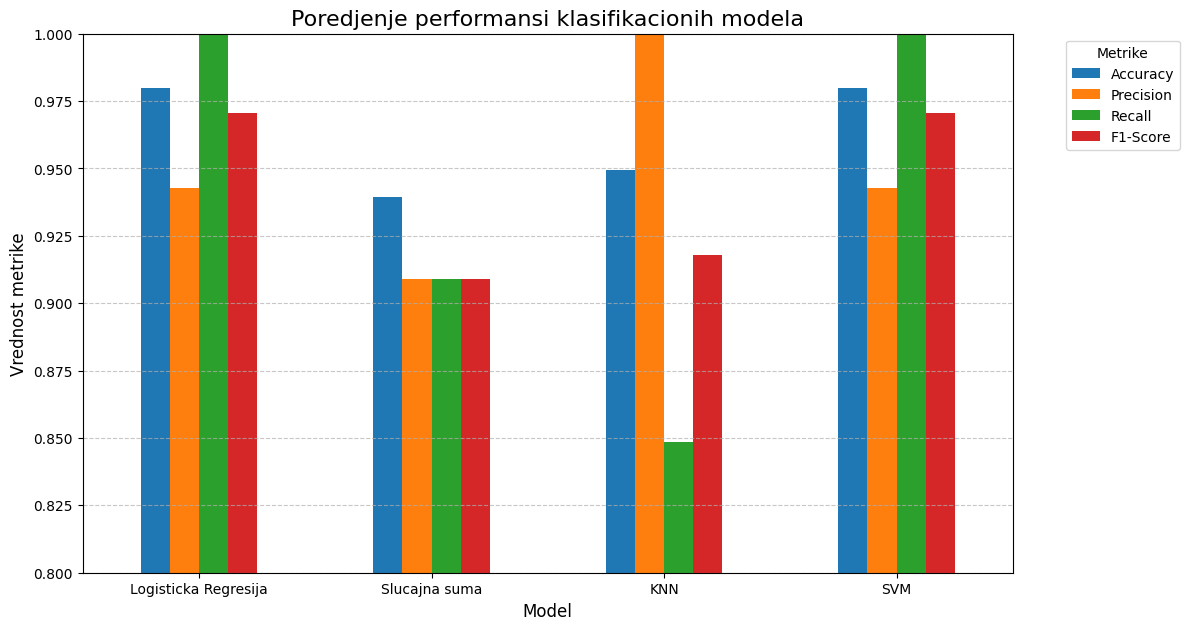


--- 10 najvažnijih atributa prema optimizovanom modelu Logističke regresije ---

             Atribut  Vaznost
       worst texture   0.4872
          worst area   0.4858
             area se   0.4734
           radius se   0.4430
        worst radius   0.4337
      mean concavity   0.4278
 mean concave points   0.4265
     worst perimeter   0.3968
worst concave points   0.3890
     worst concavity   0.3709


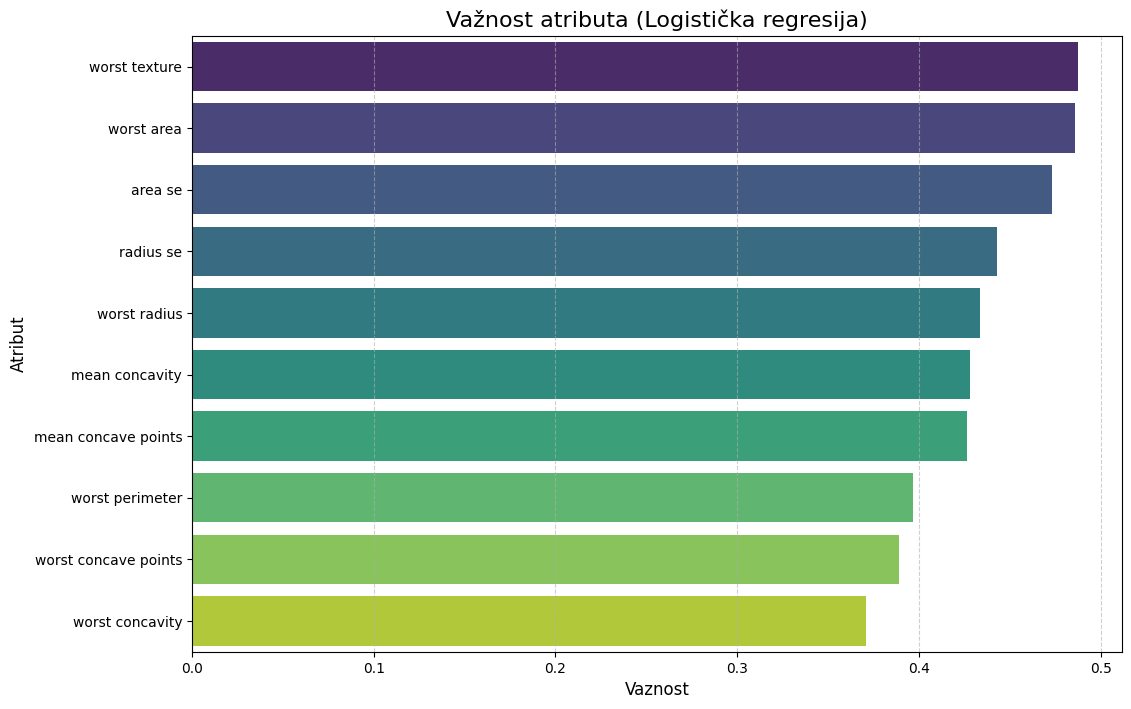

In [29]:
# Prikaz tabela performansi (ponovo)
metrics_df = pd.DataFrame(performance_metrics).T
print("--- Tabela performansi svih modela ---\n")
print(metrics_df.to_string(float_format="%.4f"))

# Vizualizacija metrika (ponovo)
metrics_df.plot(kind='bar', figsize=(12, 7), rot=0)
plt.title('Poredjenje performansi klasifikacionih modela', fontsize=16)
plt.ylabel('Vrednost metrike', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.ylim(0.8, 1.0)
plt.legend(title='Metrike', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Ponovna analiza važnosti atributa sa optimizovanim Logistic Regression modelom
lr_model_tuned = models['Logisticka Regresija']

# Logistička regresija koristi koeficijente kao meru važnosti atributa.
# Uzimamo apsolutne vrednosti jer je važna magnituda, a ne smer uticaja.
feature_importances = pd.DataFrame({
    'Atribut': X.columns,
    'Vaznost': np.abs(lr_model_tuned.coef_[0])
}).sort_values(by='Vaznost', ascending=False)

print("\n--- 10 najvažnijih atributa prema optimizovanom modelu Logističke regresije ---\n")
print(feature_importances.head(10).to_string(index=False, float_format="%.4f"))

# Vizualizacija najvažnijih atributa
plt.figure(figsize=(12, 8))
# sbn.barplot(x='Vaznost', y='Atribut', data=feature_importances.head(10), palette='viridis')
sbn.barplot(x='Vaznost', y='Atribut', data=feature_importances.head(10), hue='Atribut', palette='viridis', legend=False)
plt.title('Važnost atributa (Logistička regresija)', fontsize=16)
plt.xlabel('Vaznost', fontsize=12)
plt.ylabel('Atribut', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()